<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MO"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/MO/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


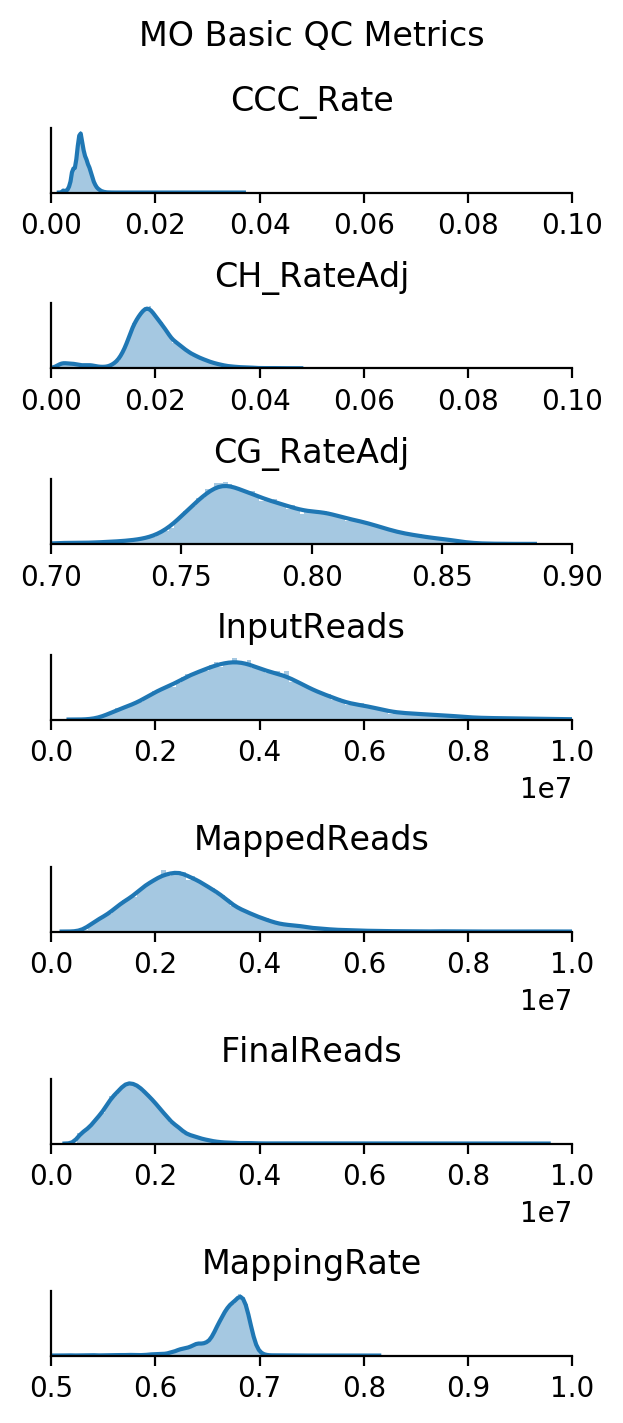

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

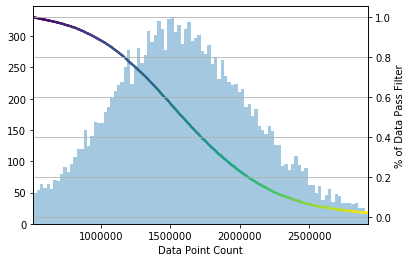

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 16780/16780 (100.0%)
CG_RateAdj passed 16780/16780 (100.0%)
CH_RateAdj passed 16780/16780 (100.0%)
FinalReads passed 16780/16780 (100.0%)
MappingRate passed 16780/16780 (100.0%)
Overall passed 16780/16780 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1161
171207 1226
171212 283
171213 1195
180104 1290
180226 1325
180227 1060
180305 1011
180306 1370
180312 1291
180409 1144
180410 1004
180501 1101
180605 1101
180612 1218


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 2077 540.9%
ad002 

2078 541.1%
ad004 2076 540.6%
ad006 2111 549.7%
ad007 2107 548.7%
ad008 2061 536.7%
ad010 2149 559.6%
ad012 2121 552.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
1A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00424,0.76626,0.76526,0.02097,0.01680,1932779.0,4061840,2765172.0,1A,...,4.680958,-14.896851,-23.386248,7.072172,IT-L4 Shc3,-5.104479,1.245065,22.172797,27.638595,True
1A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00422,0.75972,0.75870,0.02032,0.01617,1549132.0,3240886,2226396.0,1A,...,4.684537,-13.507821,-6.264395,7.254069,IT-L4 Shc3,-3.670930,-1.429920,-3.996194,36.678870,True
1A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00426,0.77770,0.77675,0.01968,0.01549,2339654.0,5217724,3577060.0,1A,...,-1.063168,-9.174500,-31.040546,35.281430,IT-L23 Cux1,4.298262,2.414790,21.864828,17.528746,True
1A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00425,0.76368,0.76267,0.01855,0.01436,2353156.0,5552334,3742394.0,1A,...,-3.020821,-8.754897,-34.883689,40.099554,IT-L23 Cux1,7.614220,4.002001,37.259851,14.266768,True
1A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00430,0.77842,0.77746,0.02109,0.01686,958205.0,2123406,1421453.0,1A,...,7.072093,-12.372558,1.988413,17.187209,IT-L5 Cdh8,-0.284260,10.215864,22.355080,-29.305726,True
1A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00450,0.76762,0.76657,0.02259,0.01817,772646.0,1686646,1142296.0,1A,...,1.270407,-11.740139,-7.461481,38.085817,IT-L23 Cux1,-1.772502,4.770433,-9.047103,-10.367370,True
1A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00499,0.78007,0.77897,0.02550,0.02061,1129187.0,2383058,1609106.0,1A,...,13.535682,-9.961327,28.746762,8.192716,IT-L5 Grik3,7.067545,-2.741640,-7.021349,41.424730,True
1A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00416,0.74495,0.74388,0.01956,0.01546,1207422.0,2472356,1706216.0,1A,...,-1.953783,-9.708794,-31.915357,37.388974,IT-L23 Cux1,5.197745,4.638354,33.055370,3.342367,True
1A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00351,0.75767,0.75682,0.01532,0.01185,980680.0,2051944,1398473.0,1A,...,-25.948494,-17.784555,-4.534514,-58.304333,CGE-Lamp5 Grk5,-0.572900,8.985583,-9.163702,3.648700,True
1A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.00423,0.77055,0.76958,0.01892,0.01475,2589267.0,5371556,3726343.0,1A,...,10.791488,9.386241,48.734495,23.521392,PT-L5 Tmtc2,-9.820209,3.813857,20.767607,-12.971505,True
